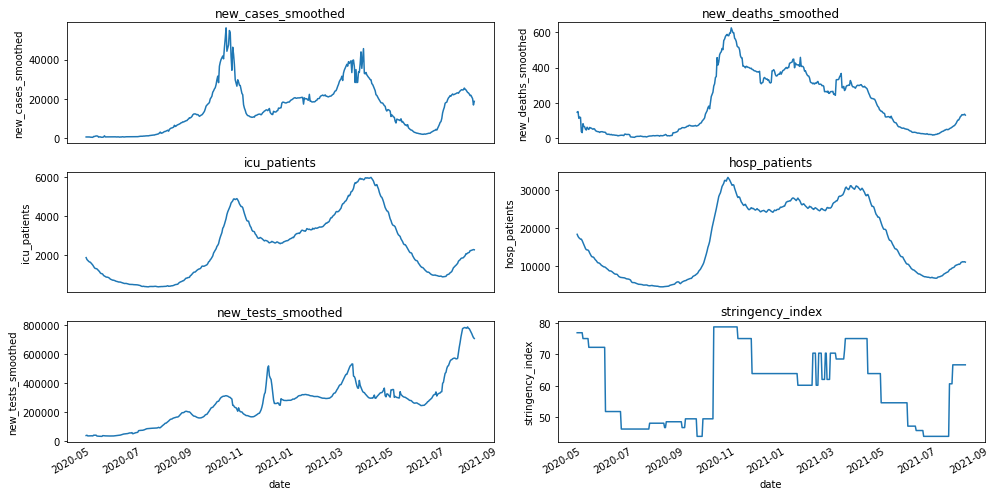

In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

xd = pd.read_csv("./ranskamv.csv", parse_dates=['date'])
xd.dropna(inplace=True)
xd['date'] = pd.to_datetime(xd.date)
df = xd.drop(['date'], axis=1)
df.index = xd.date

df_plot = df.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [2]:
# Indexing Batches
train_df = df.sort_values(by=['date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
print(train_df.head(5))

# List of considered Features
FEATURES = ['new_cases_smoothed', 'new_deaths_smoothed', 'icu_patients', 'hosp_patients', 'new_tests_smoothed', 'stringency_index'
            #, 'Month', 'Year'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['new_cases_smoothed']

# Print the tail of the dataframe
data_filtered_ext.tail()

# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_new_cases_smoothed = pd.DataFrame(data_filtered_ext['new_cases_smoothed'])
new_cases_smoothed = scaler_pred.fit_transform(df_new_cases_smoothed)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 30

# Prediction Index
index_Close = data.columns.get_loc("new_cases_smoothed")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.80)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

   new_cases_smoothed  new_deaths_smoothed  icu_patients  hosp_patients  \
0             453.714              147.286        1854.0        18409.0   
1             448.000              151.000        1754.0        17882.0   
2             394.429              112.571        1708.0        17527.0   
3             429.143              119.143        1664.0        17327.0   
4             447.857              117.429        1628.0        17122.0   

   new_tests_smoothed  stringency_index Month  Year  
0             37136.0             76.85    05  2020  
1             39112.0             76.85    05  2020  
2             34340.0             76.85    05  2020  
3             34700.0             76.85    05  2020  
4             35049.0             76.85    05  2020  
FEATURE LIST
['new_cases_smoothed', 'new_deaths_smoothed', 'icu_patients', 'hosp_patients', 'new_tests_smoothed', 'stringency_index']
(467, 6)
(344, 30, 6) (344,)
(93, 30, 6) (93,)
0.004285904994560536
0.004285904994560536


In [3]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Training the model
epochs = 30
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )



180 30 6
Epoch 1/30
22/22 [==============================] - 10s 139ms/step - loss: 0.0187 - val_loss: 0.0269
Epoch 2/30
22/22 [==============================] - 2s 93ms/step - loss: 0.0067 - val_loss: 0.0123
Epoch 3/30
22/22 [==============================] - 2s 100ms/step - loss: 0.0037 - val_loss: 0.0184
Epoch 4/30
22/22 [==============================] - 3s 148ms/step - loss: 0.0028 - val_loss: 0.0145
Epoch 5/30
22/22 [==============================] - 3s 128ms/step - loss: 0.0034 - val_loss: 0.0299
Epoch 6/30
22/22 [==============================] - 2s 95ms/step - loss: 0.0045 - val_loss: 0.0183
Epoch 7/30
22/22 [==============================] - 2s 104ms/step - loss: 0.0024 - val_loss: 0.0082
Epoch 8/30
22/22 [==============================] - 2s 100ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 9/30
22/22 [==============================] - 2s 98ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 10/30
22/22 [==============================] - 2s 107ms/step - loss: 0.0019 - val_loss:

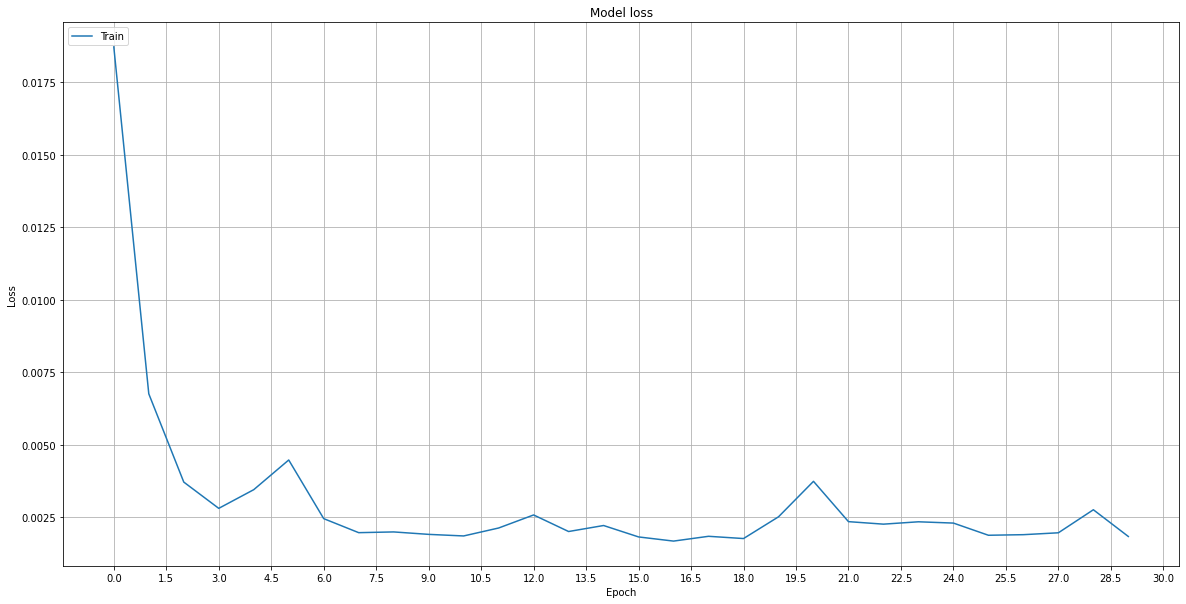

Median Absolute Error (MAE): 2425.94
Mean Absolute Percentage Error (MAPE): 25.79 %
Median Absolute Percentage Error (MDAPE): 22.54 %


In [4]:
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

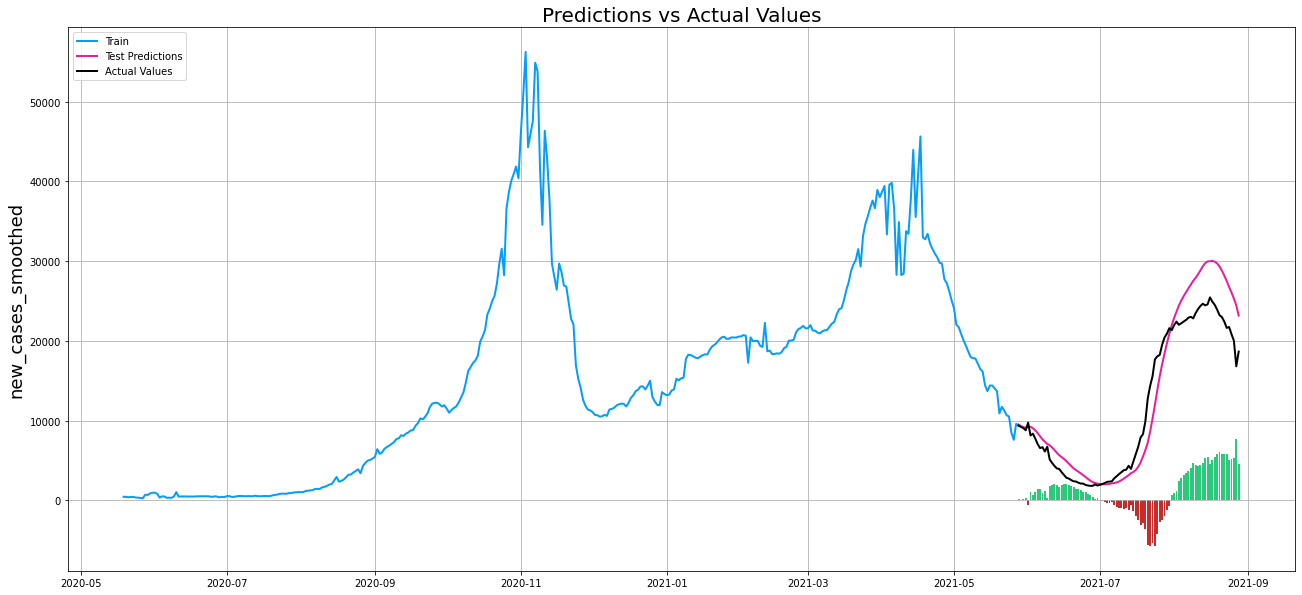

In [5]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["new_cases_smoothed"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["new_cases_smoothed"]]
xv = valid['Date']; yv = valid[["new_cases_smoothed", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel('new_cases_smoothed', fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["new_cases_smoothed"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [6]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
cases_today = np.round(new_df['new_cases_smoothed'][-1], 2)
predicted_cases = np.round(pred_price_unscaled.ravel()[0], 2)
predicted_cases1 = np.round(pred_price_unscaled.ravel()[-1], 2)
#predicted_cases1 = np.round(pred_price_unscaled.ravel()[1], 2)
change_percent = np.round(100 - (cases_today * 100)/predicted_cases, 2)

plus = '+'; minus = ''
print(f'The Cases at today was {cases_today}')
print(f'The predicted tomorrow cases is {predicted_cases} ({plus if change_percent > 0 else minus}{change_percent}%)')

The Cases at today was 18657.43
The predicted tomorrow cases is 22635.509765625 (+17.57%)
